In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron
from scipy.sparse.linalg import spsolve


---
# FD 2D elliptic PDEs
### Task 1: Poisson Solver in 2D

Implement a Python function to solve the **Poisson problem** on a square domain with homogeneous Dirichlet boundary conditions, using the **5-point finite difference Laplacian**:

$$
\nabla^2 u = -2 \sin(x) \sin(y),
\qquad (x, y) \in [0, 2\pi] \times [0, 2\pi],
$$

with
$$
u(x,0) = 0, \quad u(x, 2\pi) = 0, \quad u(0,y) = 0, \quad u(2\pi,y) = 0.
$$

#### (a) Implement the solver

In [46]:
def poisson(m):
    """
    Solve the 2D Poisson equation:
        ∇²u = -2 sin(x) sin(y),   (x,y) ∈ [0,2π] × [0,2π],
        u = 0 on the boundary.

    Parameters
    ----------
    m : int
        Number of interior grid points in each direction.

    Returns
    -------
    X, Y : 2D ndarrays
        Meshgrid of all grid points including boundaries.
    U : 2D ndarray
        Numerical solution at all grid points.
    """
    # Step 1: Discretize domain [0, 2π] × [0, 2π]
    h = (2*np.pi)/(m+1) 

    # Step 2: Build sparse matrix A for the 5-point Laplacian

    B = diags([np.ones(m-1), -4*np.ones(m), np.ones(m-1)],
        offsets=[-1, 0, 1], format='csr')

    T = diags([np.ones(m-1), np.zeros(m), np.ones(m-1)],
        offsets=[-1, 0, 1], format='csr')

    I = eye(m, format='csr')

    ## reconstruct A using Kronecker products
    A = 1/h**2 * (kron(I,B) + kron(T, I))

    # Step 3: Assemble RHS vector with f(x,y) = -2 sin(x) sin(y)
    x = np.linspace(0, 2*np.pi, m+2)
    y = np.linspace(0, 2*np.pi, m+2)
    X, Y = np.meshgrid(x, y)
    F = -2*np.sin(X[1:-1, 1:-1])*np.sin(Y[1:-1, 1:-1]) # only interior points
    F = F.reshape(m**2)  # flatten to 1D array



    # Step 4: Solve linear system AU = F
    U = spsolve(A, F)
    U = U.reshape((m, m))  # reshape back to 2D array


    # Step 5: Reconstruct solution including boundary values
    U_full = np.zeros((m+2, m+2))
    U_full[1:-1, 1:-1] = U  # interior points
    U = U_full

    return X, Y, U

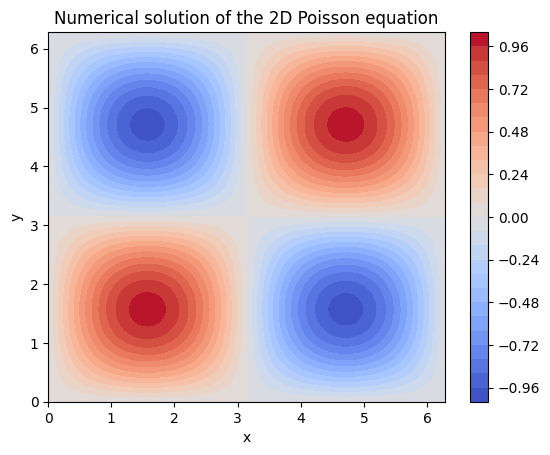

In [62]:
X, Y, U = poisson(300)
plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title('Numerical solution of the 2D Poisson equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### (b) Verify numerical convergence

1. Compute the solution for increasing values of `m` (e.g. `m = 8, 16, 32, 64`).
2. Compare with the exact solution

   $$
   u(x, y) = \sin(x)\sin(y),
   $$

   and compute the error in $\ell^2$ and $\ell^\infty$ norms.
3. Plot the errors vs. $h$ (grid spacing) in a log-log plot, and verify that the scheme is **second-order accurate**.


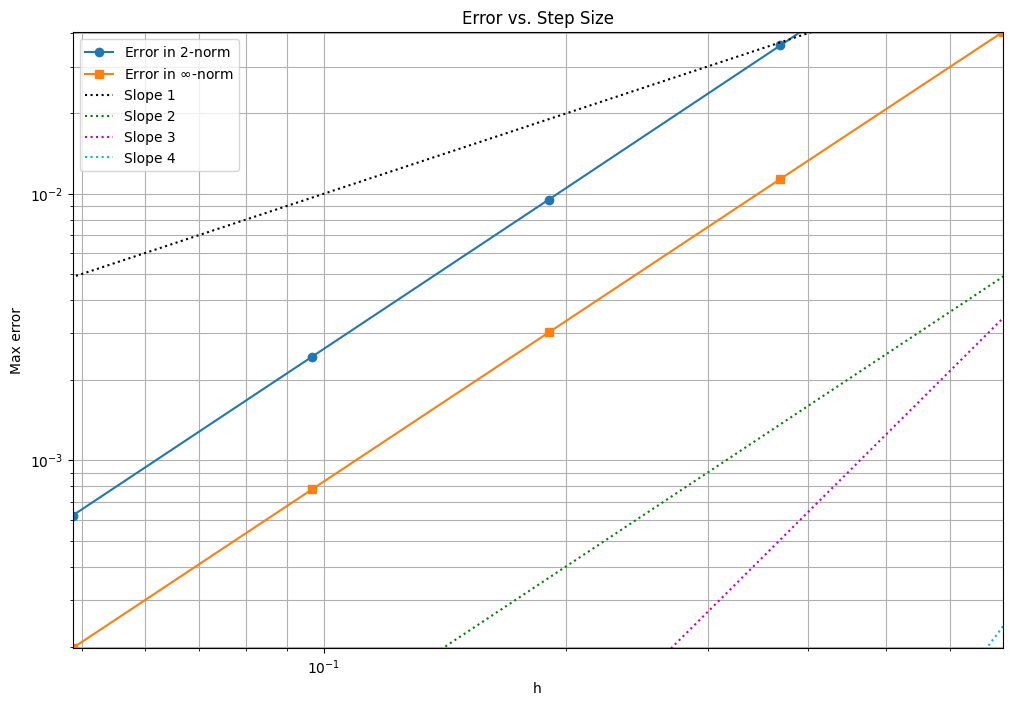

In [60]:
m_list = [8, 16, 32, 64, 128]

errors2 = []
errorsinf = []
hs = []

for m in m_list:
    X, Y, U_it = poisson(m)
    h = (2*np.pi)/(m+1)
    E = U_it - np.sin(X)*np.sin(Y)
    
    errorinf = np.max(np.abs(E))          
    error2 = np.linalg.norm(E.ravel(), 2) * h

    errors2.append(error2)
    errorsinf.append(errorinf)
    hs.append(h)

hvec = 1.0 / 2**np.arange(30)

plt.figure(figsize=(12, 8))
plt.loglog(hs, errors2, marker='o', label=r"Error in $2$-norm")
plt.loglog(hs, errorsinf, marker='s', label=r"Error in $\infty$-norm")
plt.loglog(hvec, 0.1*hvec**1, 'k:', label="Slope 1")
plt.loglog(hvec, 0.01*hvec**2, 'g:', label="Slope 2")
plt.loglog(hvec, 0.01*hvec**3, 'm:', label="Slope 3")
plt.loglog(hvec, 0.001*hvec**4, 'c:', label="Slope 4")
plt.xlim([min(hs), max(hs)])
plt.ylim([min(errorsinf), max(errorsinf)])
plt.xlabel('h')
plt.ylabel('Max error')
plt.title('Error vs. Step Size')
plt.legend()
plt.grid(True, which='both')

We can conclude that both errors decrease with $h^2$.

---
### Task 2 – Eigenvalues of the 5-Point Laplacian

Write a Python function to compute and plot the eigenvalues of the 5-point finite difference Laplacian on a square grid.


In [72]:
def laplacian_eigenvalues(m):
    """
    Compute eigenvalues of the 5-point Laplacian on a square m x m grid.

    Parameters
    ----------
    m : int
        Number of interior points in each spatial direction.

    Returns
    -------
    eig_vals : ndarray
        Array of eigenvalues of size m**2.
    """
    # we can simply use h = 1/(m+1)
    h = 1/(m+1)

    # we know the eigenvalues expression
    # we can compute them via meshgrid
    p = np.arange(1, m+1)
    k = np.arange(1, m+1)
    P, K = np.meshgrid(p, k)
    eig_vals = 2/h**2 * ((np.cos(np.pi*P*h) - 1) + (np.cos(np.pi*K*h) - 1))
    eig_vals


    return eig_vals




eig_vals = laplacian_eigenvalues(m=10)
print("Eigenvalues", eig_vals)
print("lenght:", len(eig_vals.ravel()))

Eigenvalues [[ -19.60540077  -48.21934544  -93.32640277 -151.27226724 -217.36250952
  -286.24289125 -352.33313353 -410.278998   -455.38605533 -484.        ]
 [ -48.21934544  -76.83329011 -121.94034744 -179.88621191 -245.97645419
  -314.85683592 -380.9470782  -438.89294267 -484.         -512.61394467]
 [ -93.32640277 -121.94034744 -167.04740477 -224.99326924 -291.08351152
  -359.96389325 -426.05413553 -484.         -529.10705733 -557.721002  ]
 [-151.27226724 -179.88621191 -224.99326924 -282.93913371 -349.02937599
  -417.90975772 -484.         -541.94586447 -587.0529218  -615.66686647]
 [-217.36250952 -245.97645419 -291.08351152 -349.02937599 -415.11961828
  -484.         -550.09024228 -608.03610675 -653.14316408 -681.75710875]
 [-286.24289125 -314.85683592 -359.96389325 -417.90975772 -484.
  -552.88038172 -618.97062401 -676.91648848 -722.02354581 -750.63749048]
 [-352.33313353 -380.9470782  -426.05413553 -484.         -550.09024228
  -618.97062401 -685.06086629 -743.00673076 -788.11378

In [73]:
print("Unique eigenvalues:", np.unique(eig_vals))
print("lenght unique:", len(np.unique(eig_vals)))

Unique eigenvalues: [-948.39459923 -919.78065456 -891.16670989 -874.67359723 -846.05965256
 -816.72773276 -800.95259523 -788.11378809 -750.63749048 -743.00673076
 -722.02354581 -685.06086629 -681.75710875 -676.91648848 -653.14316408
 -618.97062401 -615.66686647 -608.03610675 -587.0529218  -557.721002
 -552.88038172 -550.09024228 -541.94586447 -529.10705733 -512.61394467
 -484.         -484.         -455.38605533 -438.89294267 -426.05413553
 -417.90975772 -415.11961828 -410.278998   -380.9470782  -359.96389325
 -352.33313353 -349.02937599 -314.85683592 -291.08351152 -286.24289125
 -282.93913371 -245.97645419 -224.99326924 -217.36250952 -179.88621191
 -167.04740477 -151.27226724 -121.94034744  -93.32640277  -76.83329011
  -48.21934544  -19.60540077]
lenght unique: 52


Then $\|(A^h)^{-1}\| \leq -1/19 \approx -0.05$. Therefore is stable.